In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import numpy as np 

# Hyperparameters for data 
N_POINTS = 1000
N_CLUSTERS = 4
N_FEATURES = 2
RANDOM_STATE = 42

In [2]:
X_blobs, y_blobs = make_blobs(n_samples=N_POINTS, n_features=N_FEATURES, centers=N_CLUSTERS, cluster_std=1.5, random_state=RANDOM_STATE)

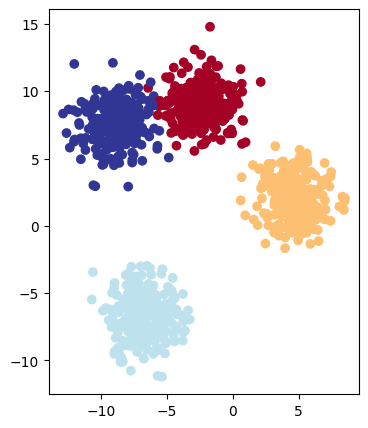

In [3]:
plt.figure(figsize=(4,5))
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs,  cmap=plt.cm.RdYlBu)

In [4]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size=0.2, random_state=RANDOM_STATE)

# device agnostic
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)
# X_train, X_test, y_train, y_test = torch.from_numpy().type(torch.float), X_test.to(device), y_train.to(device), y_test.to(device)

In [5]:
class MulticlassClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=4)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [6]:
# Initialize the model
model = MulticlassClassification()

model.to(device)
print(next(model.parameters()).device)

# optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

# loss fxn
loss_fn = nn.CrossEntropyLoss()

# activation function
# softmax = torch.nn.Softmax()

cuda:0


In [7]:
from sklearn.metrics import accuracy_score

epochs = 100

# Training loop
for epoch in range(1, epochs+1):
    model.train()
    y_logits = model(X_train)

    # if we don't specify the dim (dimension), pytorch would calculate the argmax for all the values as one. 
    # if we specify the dim=1 then we are essentially telling pytorch to go into 1st dim (each row) of the tensor and get the argmax. dim=0 would mean for each column
    y_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_probs, dim=1)
    # print(y_pred)
    acc = accuracy_score(y_true=y_train.cpu().detach().numpy(), y_pred=y_pred.cpu().detach().numpy())
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_probs = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_probs, dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_true=y_test.cpu().detach().numpy(), y_pred=test_pred.cpu().detach().numpy())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f}% | test loss: {test_loss:.5f} | test acc: {test_acc:.2f}%")

Epoch: 10 | loss: 1.23891 | acc: 0.50% | test loss: 1.19404 | test acc: 0.51%
Epoch: 20 | loss: 1.04320 | acc: 0.52% | test loss: 1.00147 | test acc: 0.55%
Epoch: 30 | loss: 0.90033 | acc: 0.66% | test loss: 0.86274 | test acc: 0.69%
Epoch: 40 | loss: 0.79145 | acc: 0.74% | test loss: 0.75840 | test acc: 0.80%
Epoch: 50 | loss: 0.70507 | acc: 0.82% | test loss: 0.67645 | test acc: 0.85%
Epoch: 60 | loss: 0.63449 | acc: 0.89% | test loss: 0.61003 | test acc: 0.90%
Epoch: 70 | loss: 0.57578 | acc: 0.92% | test loss: 0.55497 | test acc: 0.93%
Epoch: 80 | loss: 0.52641 | acc: 0.94% | test loss: 0.50874 | test acc: 0.95%
Epoch: 90 | loss: 0.48461 | acc: 0.96% | test loss: 0.46953 | test acc: 0.97%
Epoch: 100 | loss: 0.44887 | acc: 0.97% | test loss: 0.43585 | test acc: 0.98%


In [8]:
next(model.parameters()).device

device(type='cuda', index=0)

In [9]:
# Inferencing on test data 

with torch.inference_mode():
    test_logits = model(X_test)
    test_probs = torch.softmax(test_logits, dim=1)
    test_pred = torch.argmax(test_probs, dim=1)

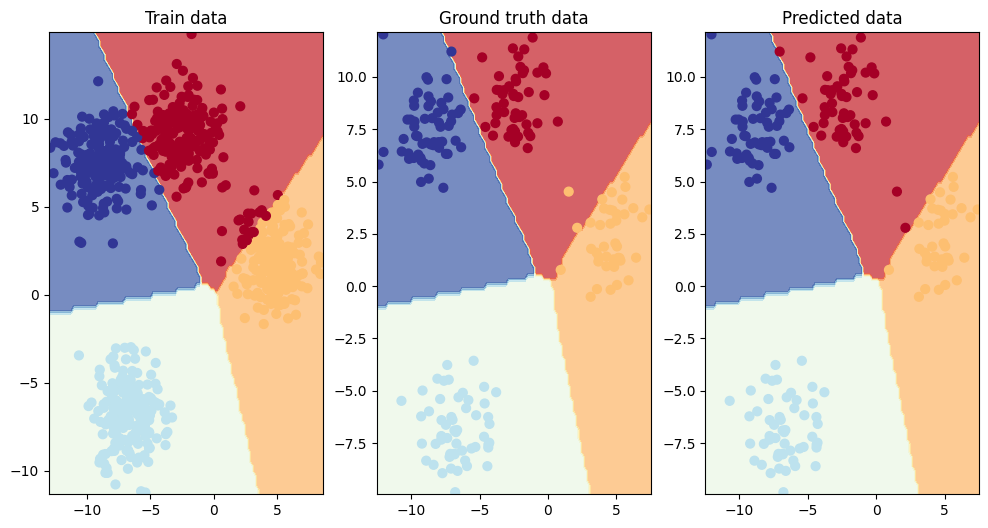

In [10]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Train data")
plot_decision_boundary(model, X_train, y_pred)

plt.subplot(1,3,2)
plt.title("Ground truth data")
plot_decision_boundary(model, X_test, y_test)

plt.subplot(1,3,3)
plt.title("Predicted data")
plot_decision_boundary(model, X_test, test_pred)

In [11]:
# Evaluating some other metrics for classification
from torchmetrics import Accuracy, Recall, Precision, F1Score, PrecisionRecallCurve

# Accuracy from torchmetrics
accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
print(accuracy(test_pred, y_test))

# Recall
recall = Recall(task='multiclass', num_classes=4).to(device)
print(recall(test_pred, y_test))

# Precision
precision = Precision(task='multiclass', num_classes=4).to(device)
print(precision(test_pred, y_test))

# Precision
f1Score = F1Score(task='multiclass', num_classes=4).to(device)
print(f1Score(test_pred, y_test))

# PrecisionRecallCurve
pr_curve  = PrecisionRecallCurve(task='multiclass', num_classes=4).to(device)
pre, rec, threshold = pr_curve(test_probs, y_test)

d:\environments\mltorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


tensor(0.9850, device='cuda:0')
tensor(0.9850, device='cuda:0')
tensor(0.9850, device='cuda:0')
tensor(0.9850, device='cuda:0')


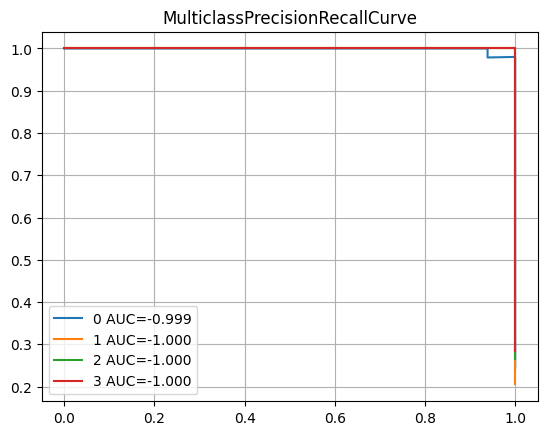

In [12]:
# Two models can be compared by plotting PRcurve, the greater the Area under the curve of a model, the better model it is.

metric = PrecisionRecallCurve(task='multiclass', num_classes=4).to(device)
metric.update(test_probs, y_test)
fig_, ax_ = metric.plot(score=True)